# 10. 워드 임베딩(Word Embedding)

## 04) 네거티브 샘플링을 이용한 Word2Vec 구현(Skip-Gram with Negative Sampling, SGNS)

### 2. 네거티브 샘플링 Skip-Gram(Skip-Gram with Negative Sampling, SGNS)

SGNS는 다음과 같이 중심 단어와 주변 단어가 모두 입력이 되고, 이 두 단어가 실제로 윈도우 크기 내에 존재하는 이웃 관계인지 그 확률을 예측합니다.

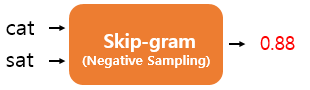

### 3. 20뉴스그룹 데이터 전처리하기

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [3]:
news_df = pd.DataFrame({'document':documents})

# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")

# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [4]:
# 현재 데이터프레임에 Null 값이 있는지 확인합니다.
news_df.isnull().values.any()

False

Null 값이 없지만, 빈 값(empy) 유무도 확인해야 합니다. 

모든 빈 값을 Null 값으로 변환하고, 다시 Null 값이 있는지 확인합니다.

In [5]:
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [6]:
# Null 값을 제거합니다.
news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 10995


In [7]:
# 불용어를 제거
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [8]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


C:\Users\seungwon\anaconda3\envs\scratch\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


단어 집합을 생성하고, 정수 인코딩을 진행합니다.

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [10]:
print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [11]:
vocab_size = len(word2idx) + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


### 4. 네거티브 샘플링을 통한 데이터셋 구성하기

어떤 전처리가 수행되는지 그 결과를 확인하기 위해서 상위 10개의 뉴스그룹 샘플에 대해서만 수행해봅시다.

In [12]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [13]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(sure (59), biased (3278)) -> 1
(austria (4866), sphinx (6430)) -> 0
(unfortunate (4295), power (68)) -> 1
(israeli (442), cooperate (7244)) -> 0
(report (581), cruisers (16952)) -> 0


In [14]:
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 10


In [15]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2220
2220


이 작업을 모든 뉴스그룹 샘플에 대해서 수행합니다.

In [16]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

### 5. Skip-Gram with Negative Sampling(SGNS) 구현하기

In [17]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

하이퍼파라미터인 임베딩 벡터의 차원은 100으로 정하고, 두 개의 임베딩 층을 추가합니다.

각 임베딩 테이블은 중심 단어와 주변 단어 각각을 위한 임베딩 테이블이다.

In [18]:
embedding_dim = 50

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding = Embedding(vocab_size, embedding_dim)(c_inputs)

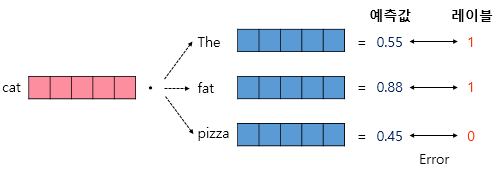

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        3213850     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        3213850     input_2[0][0]                    
______________________________________________________________________________________________

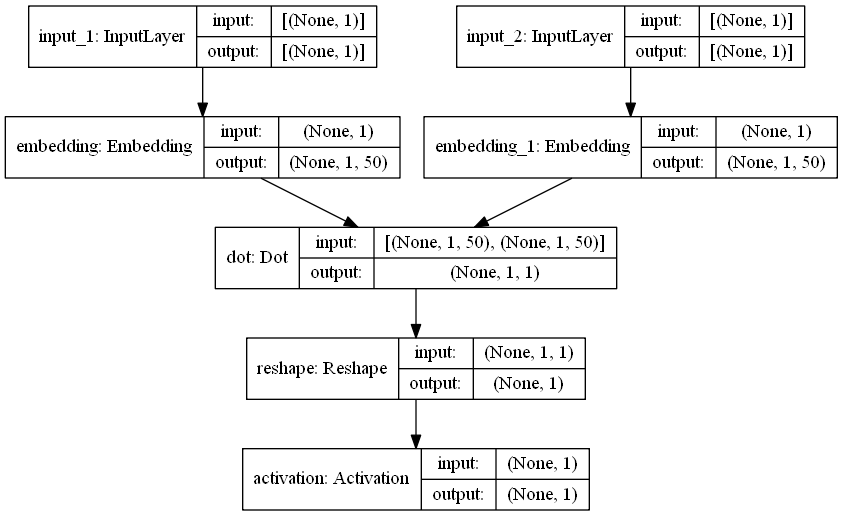

In [19]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, 
           show_layer_names=True, rankdir='TB')

In [20]:
for epoch in range(0, 5):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)
    print('Epoch :', epoch+1, 'Loss :', loss)

Epoch : 1 Loss : 4742.369120642543
Epoch : 2 Loss : 3665.2332644686103
Epoch : 3 Loss : 3511.465811006725
Epoch : 4 Loss : 3427.1823211349547
Epoch : 5 Loss : 3328.604360949248


### 6. 결과 확인하기

학습된 임베딩 벡터들을 vector.txt에 저장합니다. 

그 후 이를 gensim의 models.KeyedVectors.load_word2vec_format()으로 로드하면 쉽게 단어 벡터 간 유사도를 구할 수 있습니다.

In [22]:
import gensim

f = open('results/vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embedding_dim))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 모델 로드
w2v = gensim.models.KeyedVectors.load_word2vec_format('results/vectors.txt', binary=False)

In [23]:
w2v.most_similar(positive=['soldiers'])

[('reject', 0.9460220336914062),
 ('terrorist', 0.9444746971130371),
 ('innocent', 0.9419151544570923),
 ('palestinians', 0.9417338967323303),
 ('israeli', 0.9406510591506958),
 ('troops', 0.9403395652770996),
 ('extermination', 0.9402216672897339),
 ('fled', 0.9401530027389526),
 ('writings', 0.9393635392189026),
 ('armed', 0.9393497705459595)]

In [24]:
w2v.most_similar(positive=['doctor'])

[('zionist', 0.8931224942207336),
 ('rape', 0.8919854760169983),
 ('criminal', 0.8888155221939087),
 ('existance', 0.8877637386322021),
 ('threat', 0.8841276168823242),
 ('rules', 0.8800616264343262),
 ('islamic', 0.8800019025802612),
 ('preach', 0.8799349069595337),
 ('shouted', 0.8799185156822205),
 ('nations', 0.8796791434288025)]

In [25]:
w2v.most_similar(positive=['police'])

[('officers', 0.8684234023094177),
 ('handguns', 0.8629216551780701),
 ('refused', 0.8620627522468567),
 ('foster', 0.8595556616783142),
 ('began', 0.8558581471443176),
 ('accordance', 0.8525872230529785),
 ('villagers', 0.8508160710334778),
 ('agents', 0.8502941131591797),
 ('courts', 0.849624752998352),
 ('assault', 0.8481619358062744)]

In [26]:
w2v.most_similar(positive=['knife'])

[('flee', 0.893335223197937),
 ('proof', 0.8834406733512878),
 ('century', 0.8834208846092224),
 ('arguing', 0.8828367590904236),
 ('raped', 0.8804145455360413),
 ('risen', 0.8796252608299255),
 ('kibbutz', 0.8769161105155945),
 ('welfare', 0.8754045367240906),
 ('country', 0.8747388124465942),
 ('poverty', 0.8746842741966248)]

In [27]:
w2v.most_similar(positive=['engine'])

[('switched', 0.6602391004562378),
 ('moselecw', 0.6542754173278809),
 ('dealership', 0.63975590467453),
 ('spec', 0.6179273724555969),
 ('chilton', 0.6066023111343384),
 ('allows', 0.6022602915763855),
 ('discount', 0.5996115207672119),
 ('replacing', 0.5994131565093994),
 ('setenv', 0.5974012017250061),
 ('attachment', 0.5964007377624512)]